In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!unzip "/content/drive/MyDrive/PlantVillage.zip" -d "/content/plantvillage"

unzip:  cannot find or open /content/drive/MyDrive/PlantVillage.zip, /content/drive/MyDrive/PlantVillage.zip.zip or /content/drive/MyDrive/PlantVillage.zip.ZIP.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix, classification_report
#print(tf.__version__)
#from tensorflow import keras
#from tensorflow.keras import callbacks, layers, Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
IMAGE_SIZE   = 224
TARGET_SIZE  = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE  = (IMAGE_SIZE, IMAGE_SIZE, 3)
BATCH_SIZE   = 32
EPOCHS_FROZEN     = 10       # train head only
EPOCHS_FINE_TUNE  = 15       # fine-tune top of backbone
FREEZE_UP_TO      = -30      # unfreeze last 30 layers
DATA_ROOT_RAW     = "/Users/shekhar/Desktop/tf/dataset"
DATA_ROOT_SPLIT   = "/Users/shekhar/Desktop/tf/dataset-split"
SEED              = 42

In [3]:
train_dir = os.path.join(DATA_ROOT_SPLIT, "train")
val_dir   = os.path.join(DATA_ROOT_SPLIT, "val")
test_dir  = os.path.join(DATA_ROOT_SPLIT, "test")

train_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode="nearest"
)

val_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED
)
val_data = val_aug.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED
)
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False          # ⚠️ keep order for evaluation
)

NUM_CLASSES  = len(train_data.class_indices)
CLASS_NAMES  = list(train_data.class_indices.keys())

Found 49179 images belonging to 39 classes.
Found 6139 images belonging to 39 classes.
Found 6168 images belonging to 39 classes.


In [5]:
label_map = train_data.class_indices

with open("labels.txt", "w") as f:
    for label, index in label_map.items():
        f.write(f"{index}: {label}\n")

print("Saved class labels to labels.txt")

Saved class labels to labels.txt


In [13]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=INPUT_SHAPE
)
base_model.trainable = False   # Stage 1: freeze backbone

# Custom classification head
inputs = keras.Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 39)             │        10,023 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,058,279 (11.67 MB)

 Trainable params: 798,759 (3.05 MB)

 Non-trainable params: 2,259,520 (8.62 MB)

In [14]:
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_frozen.keras", monitor="val_accuracy",
    save_best_only=True, mode="max", verbose=1
)
early_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

In [15]:
history_frozen = model.fit(
    train_data,
    epochs=EPOCHS_FROZEN,
    steps_per_epoch=200,
    validation_steps=10,
    validation_data=val_data,
    callbacks=[ckpt_cb, early_cb]
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5170 - loss: 1.9066 - precision: 0.7902 - recall: 0.3863 
Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to best_frozen.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 55s 266ms/step - accuracy: 0.5177 - loss: 1.9032 - precision: 0.7906 - recall: 0.3871 - val_accuracy: 0.8000 - val_loss: 0.6114 - val_precision: 0.8973 - val_recall: 0.7375
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.8035 - loss: 0.6301 - precision: 0.8900 - recall: 0.7359 
Epoch 2: val_accuracy improved from 0.80000 to 0.87187, saving model to best_frozen.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 283ms/step - accuracy: 0.8035 - loss: 0.6300 - precision: 0.8900 - recall: 0.7360 - val_accuracy: 0.8719 - val_loss: 0.3579 - val_precision: 0.9298 - val_recall: 0.8281
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8310 - loss: 0.5417 - precision: 0.8876 - recall: 0.7787 
Epoch 3: val_accuracy improved from 0.871

2025-05-21 15:48:28.762213: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/shekhar/Desktop/tf/env/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 8: val_accuracy did not improve from 0.90000
200/200 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.8844 - loss: 0.3747 - precision: 0.9174 - recall: 0.8553 - val_accuracy: 0.8875 - val_loss: 0.2990 - val_precision: 0.9274 - val_recall: 0.8781
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.8844 - loss: 0.3574 - precision: 0.9096 - recall: 0.8552  
Epoch 9: val_accuracy improved from 0.90000 to 0.92500, saving model to best_frozen.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 334ms/step - accuracy: 0.8844 - loss: 0.3574 - precision: 0.9096 - recall: 0.8552 - val_accuracy: 0.9250 - val_loss: 0.2612 - val_precision: 0.9417 - val_recall: 0.9094
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8975 - loss: 0.3324 - precision: 0.9230 - recall: 0.8750 
Epoch 10: val_accuracy did not improve from 0.92500
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 321ms/step - accuracy: 0.8975 - loss: 0.3324 - precision: 0.9230 - recall: 0.8749 - val_accuracy: 0.8906 - val_loss

In [18]:
base_model.trainable = True
for layer in base_model.layers[:FREEZE_UP_TO]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

ckpt_cb_ft = tf.keras.callbacks.ModelCheckpoint(
    "best_finetune.keras", monitor="val_accuracy",
    save_best_only=True, mode="max", verbose=1
)
early_cb_ft = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True
)

history_ft = model.fit(
    train_data,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=val_data,
    steps_per_epoch=200,
    validation_steps=20,
    callbacks=[ckpt_cb_ft, early_cb_ft]
)

Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8360 - loss: 0.5125 - precision: 0.8727 - recall: 0.8109  
Epoch 1: val_accuracy improved from -inf to 0.23594, saving model to best_finetune.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 85s 407ms/step - accuracy: 0.8361 - loss: 0.5123 - precision: 0.8728 - recall: 0.8109 - val_accuracy: 0.2359 - val_loss: 10.6936 - val_precision: 0.2483 - val_recall: 0.2297
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8861 - loss: 0.3550 - precision: 0.9074 - recall: 0.8661  
Epoch 2: val_accuracy improved from 0.23594 to 0.47344, saving model to best_finetune.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 410ms/step - accuracy: 0.8861 - loss: 0.3549 - precision: 0.9075 - recall: 0.8662 - val_accuracy: 0.4734 - val_loss: 3.3420 - val_precision: 0.4941 - val_recall: 0.4578
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8984 - loss: 0.3293 - precision: 0.9169 - recall: 0.8815  
Epoch 3: val_accuracy improved fr

2025-05-21 16:06:26.602576: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy improved from 0.87187 to 0.89844, saving model to best_finetune.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 59s 297ms/step - accuracy: 0.9371 - loss: 0.2024 - precision: 0.9443 - recall: 0.9269 - val_accuracy: 0.8984 - val_loss: 0.4649 - val_precision: 0.9092 - val_recall: 0.8922
Epoch 9/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9378 - loss: 0.1989 - precision: 0.9499 - recall: 0.9238  
Epoch 9: val_accuracy did not improve from 0.89844
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - accuracy: 0.9378 - loss: 0.1989 - precision: 0.9499 - recall: 0.9238 - val_accuracy: 0.8781 - val_loss: 0.4426 - val_precision: 0.8889 - val_recall: 0.8750
Epoch 10/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9374 - loss: 0.1956 - precision: 0.9499 - recall: 0.9300  
Epoch 10: val_accuracy did not improve from 0.89844
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 394ms/step - accuracy: 0.9374 - loss: 0.1956 - precision: 0.9499 - recall: 0.9300 - val_accuracy: 0.8707 - val_l


Evaluating on test set …
193/193 ━━━━━━━━━━━━━━━━━━━━ 47s 243ms/step - accuracy: 0.9434 - loss: 0.2376 - precision: 0.9457 - recall: 0.9400
Test  acc=0.9408  prec=0.9460  rec=0.9369
193/193 ━━━━━━━━━━━━━━━━━━━━ 49s 250ms/step

Confusion Matrix:
 [[ 72   4   7 ...   0   0   0]
 [  0  99   0 ...   0   0   1]
 [  0   0 100 ...   0   0   0]
 ...
 [  0   0   0 ... 499   0   2]
 [  0   0   0 ...   0  88   4]
 [  0   0   0 ...   0   0 159]]


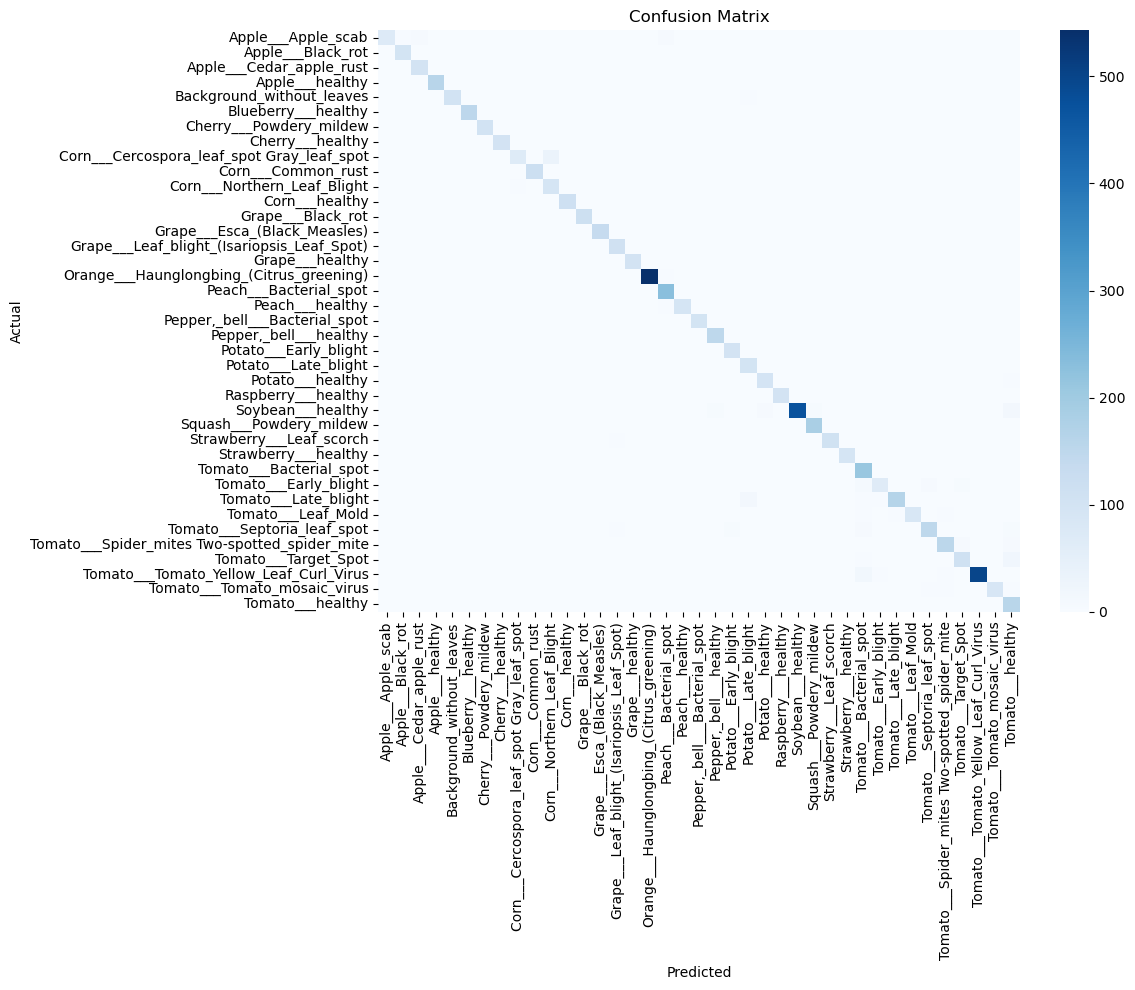


Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.72      0.84       100
                            Apple___Black_rot       0.93      0.99      0.96       100
                     Apple___Cedar_apple_rust       0.92      1.00      0.96       100
                              Apple___healthy       0.95      0.98      0.96       165
                    Background_without_leaves       1.00      0.90      0.94       115
                          Blueberry___healthy       0.99      1.00      1.00       151
                      Cherry___Powdery_mildew       1.00      0.97      0.99       106
                             Cherry___healthy       1.00      1.00      1.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.68      0.77       100
                           Corn___Common_rust       0.94      1.00      0.97       120
                  

In [20]:
print("\nEvaluating on test set …")
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data, verbose=1)
print(f"Test  acc={test_acc:.4f}  prec={test_prec:.4f}  rec={test_rec:.4f}")

# Confusion matrix & classification report
y_probs = model.predict(test_data, verbose=1)
y_pred  = np.argmax(y_probs, axis=1)
y_true  = test_data.classes

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=False, fmt='d',
            cmap="Blues",
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

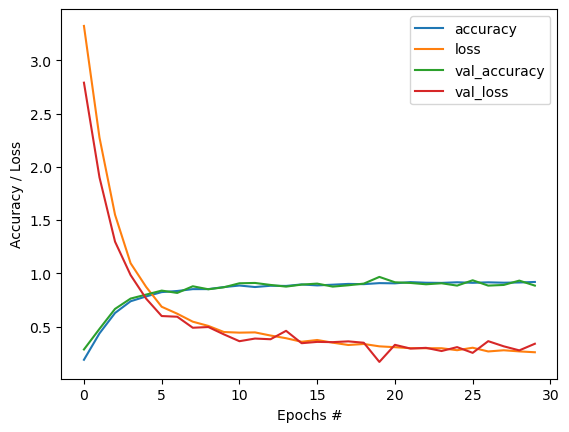

In [30]:
hist = history.history

plt.plot(hist["loss"], label="loss")

if "val_loss" in hist:
    plt.plot(hist["val_loss"], label="val_loss")

plt.xlabel("Epochs #")
plt.legend()

plt.show()

In [21]:
model.save("my_voila.h5")
model.save('my_voila.keras')

In [22]:


# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: quantization
tflite_model = converter.convert()

# Save the model
with open("voila.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/dx/k0n47xdx1434h0nhdgcwz1yw0000gn/T/tmpo2o535zi/assets


INFO:tensorflow:Assets written to: /var/folders/dx/k0n47xdx1434h0nhdgcwz1yw0000gn/T/tmpo2o535zi/assets


Saved artifact at '/var/folders/dx/k0n47xdx1434h0nhdgcwz1yw0000gn/T/tmpo2o535zi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_482')
Output Type:
  TensorSpec(shape=(None, 39), dtype=tf.float32, name=None)
Captures:
  6295074800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017214544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017217360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017217184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017366768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017218768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017373104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017375744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017371696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13017373632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130173

W0000 00:00:1747825117.381400 1403575 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747825117.381841 1403575 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-21 16:28:37.382945: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/dx/k0n47xdx1434h0nhdgcwz1yw0000gn/T/tmpo2o535zi
2025-05-21 16:28:37.388553: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-21 16:28:37.388561: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/dx/k0n47xdx1434h0nhdgcwz1yw0000gn/T/tmpo2o535zi
I0000 00:00:1747825117.443182 1403575 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-05-21 16:28:37.453511: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-21 16:28:37.861668: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder